# Lab 2: Sequence Models

In this lab, you will implement a **Hidden Markov Model (HMM)**. HMMs specify a **joint** probability over **observations** and **hidden states**. 

This is what we will do:

1. **Estimate** a simple HMM model from training data (supervised learning)
2. Find the *best* sequence of hidden states for a given sequence of observations (we define "best" in 2 different ways!)

# Rules
* The assignment should be submitted to **Blackboard** as `.ipynb` (without data files or zipping). Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.
 
* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header(!).

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells. 
* Don't change the names of provided functions and variables or arguments of the functions. 
* Leave the output of your code in the output cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>

The initial layout of the project was:
* Jose Luis Cano-Manuel Claver: Ex 1 + 2 + 4 
* Ruben Kole: Ex 4 
* Raquel González López: Ex 3 + 4 

but everyone assisted on each other's sections.  

# Set up

In [ ]:
# Import modules
%matplotlib inline
import numpy as np
from collections import defaultdict, namedtuple

# Notation

$ \Sigma := \{ o_1, \dots, o_J \} $ is our set of **observations**

$\Lambda := \{s_1, \dots, s_K \}$ is our set of **state labels**

$\Sigma^*$ are **all possible sequences** of observations (including empty string $\epsilon$)

$\Lambda^*$ all possible sequences of hidden states (including empty string $\epsilon$)

> Extra info: we can say that $\Sigma^*$ is the [Kleene-closure](https://en.wikipedia.org/wiki/Kleene_star) of $\Sigma$, and $\Lambda^*$ the Kleene-closure of $\Lambda$.

# A simple example: The Baby HMM

We start with a simple example, so that we can easily verify that our code is correct.

Consider that we are modeling how a baby behaves. We observe the baby doing the following things: laughing (`laugh`), crying (`cry`), and sleeping (`sleep`). This is our set $\Sigma$ of **observations**. 

We presume that, at any moment, the baby can be either `hungry`, `bored`, or `happy`. Since babies cannot talk, each of these states is hidden. This is our set $\Lambda$ of **hidden states**.

**Now the question is: if we have a series of observations, can we predict what hidden states the baby went through?**

To tackle this problem, we assume that the baby behaves like a **1st order discrete Markov chain**: the baby's current state only depends on its previous hidden state. The baby can be described as an HMM. (Yay!)

For example, assume we observed the baby doing the following:

```
sleep cry laugh cry
cry cry laugh sleep
```

We will use these sequences as our **test set**. We can try to find out the states of the baby for those observations.

Now, to train our model, we will need some examples of **observations** and **states**; this is our **training set**:

```
laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy
```

So we have **pairs** observation/state.

In [ ]:
# read in test data
test_data = """sleep cry laugh cry
cry cry laugh sleep"""

def test_reader(test_lines):
    for line in test_lines.splitlines():
        yield line.split()

test_set = list(test_reader(test_data))

# read in train data
train_data = """laugh/happy cry/bored cry/hungry sleep/happy
cry/bored laugh/happy cry/happy sleep/bored
cry/hungry cry/bored sleep/happy"""

# for convenience, we define a Observation-State pair class
# fyi, more about namedtuple: 
# https://docs.python.org/3/library/collections.html#collections.namedtuple
Pair = namedtuple("Pair", ["obs", "state"])
Pair.__repr__ = lambda x: x.obs + "/" + x.state

def train_reader(train_lines):
    for line in train_data.splitlines():
        # a pair is a string "observation/state" so we need to split on the "/"
        yield [Pair(*pair.split("/")) for pair in line.split()]

training_set = list(train_reader(train_data))

# print the results
print("test set (observations):")
for seq in test_set:
    print(seq)
print("\ntraining set (observation/state pairs):")
for seq in training_set:
    print(seq)

test set (observations):
['sleep', 'cry', 'laugh', 'cry']
['cry', 'cry', 'laugh', 'sleep']

training set (observation/state pairs):
[laugh/happy, cry/bored, cry/hungry, sleep/happy]
[cry/bored, laugh/happy, cry/happy, sleep/bored]
[cry/hungry, cry/bored, sleep/happy]


## Vocabularies 

The `numpy` library is very practical when working with numeric vectors and matrices. Examples in this notebook heavily uses numpy arrays. It is recommended that you understand how simple arithmetic operation work on the arrays. You can also find very useful methods like `max` or `argmax` that will save several lines of code. You might find the following links useful: [NumPy Reference](https://numpy.org/doc/stable/reference/), [NumPy cheatsheets](https://blog.finxter.com/collection-10-best-numpy-cheat-sheets-every-python-coder-must-own/) 

It's going to be very useful if we can map states and observations to integers, so that we can identify them by a number. If we don't do this, then our implementation will be longer and much slower (This is relevant when we work with larger data, e.g. for POS tagging).

Make sure you understand what is going on here: every time we look up an observation or state, the `defaultdict` will create a new key (index) if it has not seen that key (state or observation) before.

In [ ]:
# create mappings from state/obs to an ID
state2i = defaultdict(lambda: len(state2i))
obs2i = defaultdict(lambda: len(obs2i))

for seq in training_set:
    for example in seq:
        _ = state2i[example.state]
        _ = obs2i[example.obs]
        
print("\nOur vocabularies:")
print(state2i)
print(obs2i)


Our vocabularies:
defaultdict(<function <lambda> at 0x7f8ed50153f0>, {'happy': 0, 'bored': 1, 'hungry': 2})
defaultdict(<function <lambda> at 0x7f8ed5015360>, {'laugh': 0, 'cry': 1, 'sleep': 2})


The HMM for the first training set sequence looks like this:

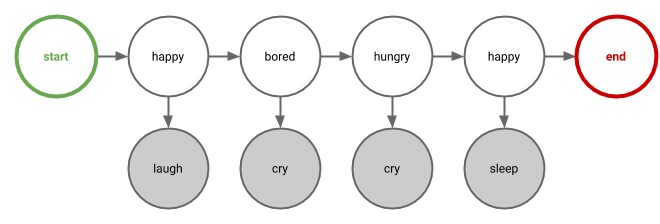

Now, we will **estimate** the following probability distributions:

- initial: $P( s_k \,|\, \texttt{start})$
- transition: $P( s_k \,|\, s_l )$
- final: $P(\texttt{stop} \,|\, s_k )$
- emission: $P( o_l \,|\, s_k)$

These distributions are all we need. Remember that:

- the probability of transitioning to a state $s_k$ only depends on one previous state $s_l$ (1st order Markov assumption).
- emitting an observation $o_l$ only depends on the state $s_k$.

## Finding the Maximum Likelihood Parameters

Now we would like to know what those distributions look like from our data. This is called **estimation**. Given our training data, we count how many times each event occurs and normalize the counts to form proper probability distributions. 

Let's first do counts for the start probabilities:

In [ ]:
# we can get the number of states and observations from our dictionaries
num_states = len(state2i)
num_observations = len(obs2i)

# this creates a vector of length `num_states` filled with zeros
counts_start = np.zeros(num_states)

# now we count 1 every time a sequence starts with a certain state
# we look up the index for the state that we want to count using the `state2i` dictionary
for seq in training_set:
    counts_start[state2i[seq[0].state]] += 1.

print(counts_start)

[1. 1. 1.]


We see each state once at the beginning of a sequence in the training set, so that is why we have a count of 1 for each of them.

We now **normalize** those counts, so that we obtain a probability distribution:

In [ ]:
# since p_start is a numpy object, we can call sum on it; easy!
total = counts_start.sum()

# normalize: divide each count by the total
p_start = counts_start / total  
print(f"start --> {p_start}")

start --> [0.33333333 0.33333333 0.33333333]


We now turn to the **transition probabilities** and **stop probabilities**. We count, and then we normalize:

In [ ]:
# we can transition from any state to any other state in principle,
# so we create a matrix filled with zeros so that we can count any pair of states
# in practice, some transitions might not occur in the training data
counts_trans = np.zeros([num_states, num_states])

# for the final/stop probabilities, we only need to store `num_states` values.
# so we use a vector
counts_stop = np.zeros(num_states)

# now we count transitions, one sequence at a time
for seq in training_set:
    for i in range(1, len(seq)):
        
        # convert the states to indexes
        prev_state = state2i[seq[i-1].state]
        current_state = state2i[seq[i].state]
        
        # count
        counts_trans[current_state, prev_state] += 1.
        # note that the order of states/indices in this matrix
        # follows conditional probability order p(q_i|q_{i-1})
        # not the transition matrix A_{i-1}_{i}

# count final states
for seq in training_set:
    state = state2i[seq[-1].state]
    counts_stop[state] += 1.

# print the counts
print("Transition counts:")
print(counts_trans)

print("Final counts:")
print(counts_stop)

Transition counts:
[[1. 2. 1.]
 [2. 0. 1.]
 [0. 1. 0.]]
Final counts:
[2. 1. 0.]


Now we can normalize again. We will need to collect the total counts per state.
Take some time to understand that the totals consist of the transition counts AND the final counts.

In [ ]:
# Useful trick: np.sum(m, 0) sums matrix m along the first dimension (with index 0).
# Note that after summing the dimension disappears
print(counts_trans.sum(0))

[3. 3. 2.]


In [ ]:
total_per_state = counts_trans.sum(0) + counts_stop
print(f"Total counts per state:\n{total_per_state}\n")

# now we normalize
# here '/' works one column at a time in the matrix
p_trans = counts_trans / total_per_state
print(f"Transition probabilities:\n{p_trans}\n")

# here '/' divides the values in each corresponding index in the 2 vectors
p_stop = counts_stop / total_per_state
print(f"Final probabilities:\n{p_stop}\n")

Total counts per state:
[5. 4. 2.]

Transition probabilities:
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]

Final probabilities:
[0.4  0.25 0.  ]



**So far so good!** Now let's take care of **emission probabilities**.

In [ ]:
# now we create a matrix to keep track of emission counts
# in principle any states can emit any observation
# so we need a matrix again: 
# 1st dimension is for observations, 2nd is for states
# the dim. order follows conditional probabilities p(o|s)
counts_emiss = np.zeros([num_observations, num_states])

# count
for seq in training_set:
    for obs, state in seq:
        obs = obs2i[obs]
        state = state2i[state]
        counts_emiss[obs][state] += 1.

# normalize
p_emiss = counts_emiss / counts_emiss.sum(0)

print(f"emission counts:\n{counts_emiss}\n")
print(f"p_emiss:\n{p_emiss}\n")

emission counts:
[[2. 0. 0.]
 [1. 3. 2.]
 [2. 1. 0.]]

p_emiss:
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]



This is a good moment for a sanity check. First, take a look at the training set to see if these probabilities are correct, i.e. check if  for each state $s_k$: $$\sum_l P(s_l \,|\, s_k) = 1.0$$ Note that this includes transitions to "stop" state, so you have to take those into account.

# Ex1 [2.5pt] Sanity check
Write a function `sanity_check(...)` that checks if all distributions are correct. If (and only if) it discovers an incorrect distribution, it should throw an **AssertionError**. 

If you want, you can include some print statements to see what is going on. 

**[Python hint]**: use python [assert](https://www.tutorialspoint.com/python/assertions_in_python.htm) statements.


In [ ]:
def almost_one(p, eps=1e-3):
    """ Return true or false based on whether the input is close to 1.
    """
    return (1.-eps) < p < (1. + eps)

def sanity_check(p_start=None, p_trans=None, p_stop=None, p_emiss=None):

    # Check if p_start is a valid probability distribution
    assert almost_one(p_start.sum()), "Invalid p_start distribution"

    # Check if p_trans is a valid probability distribution for each state with p_stop
    for i in range(np.size(p_trans[0])) :
      assert almost_one(p_trans.sum(0)[i]+p_stop[i]), f"Invalid p_trans distribution for state {state}"

    # Check if p_emiss is a valid probability distribution for each state
    for i in range(np.size(p_trans[0])) :
      assert almost_one(p_emiss.sum(0)[i]), f"Invalid p_emiss distribution for state {state}"

    # If all checks pass, return True (optional)
    return True

In [ ]:
# TEST 1
# you can try your function out like this
# (do not use this cell for your solution)
try:
    sanity_check(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
    print("All good!")
except AssertionError as e:
    print("There was a problem: %s" % str(e))

All good!


# Decoding a sequence

Ok, so we have estimated a model. Great. Now what? Well, now we can **decode**! 

Given an observation sequence $o_1, o_2, \dots, o_N$, we want to find the sequence of hidden states $s^* = s^*_1, s^*_2, \dots, s^*_N$ that **best** explains those observations.

But what does "best" mean?

1. If we are interested in the best **global** assignment of states to the sequence as a whole, we can use the **Viterbi** algorithm. 
2. If we care more about minimizing the **local** error of getting each $s_i$ right, we can use **posterior decoding** (also called *max marginal decoding*). *(This is a bonus exercise at the end!)*


### Decoding: The Viterbi Algorithm

Viterbi gives us the best global hidden state sequence, i.e.:

$$ \begin{array}{lll}
s^* &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N \,|\, o_1, o_2, \dots, o_N ) \\
    &=& \arg\max_{s = s_1, s_2, \dots, s_N} P(s_1, s_2, \dots, s_N, o_1, o_2, \dots, o_N ) 
\end{array}$$

To explain Viterbi we will make use of a **trellis**, a kind of graph that shows us the possible states for each time step. 

For our earlier example, the trellis looks like this:

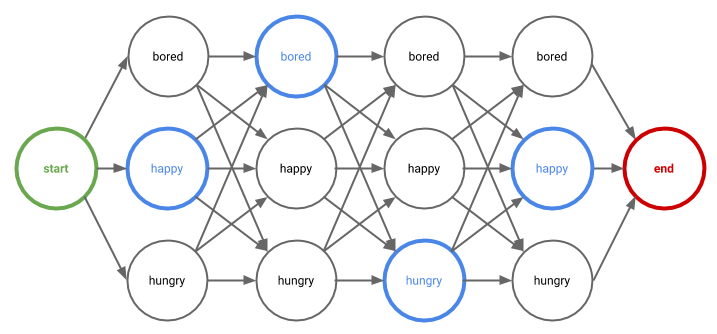

Note, that we can now label the edges of this trellis with the following probabilities:

- $P_{\text start}(s_k \,|\, \text{start})$ on the three edges from "start"
- $P_{\text stop}(\text{stop} \,|\, s_k)$ on the three edges leading to "stop"
- $P_{\text trans}(s_k \,|\, s_{l})$ on each remaining edge from state $s_l$ to $s_k$
- $P_{\text emiss}(o \,|\, s_k)$ from each state $s_k$, to an observation $o$ made from that state (not shown here)

Do you see that our trellis nicely shows the independence assumptions of the HMM?

### A Naive approach to get the best sequence

To see why the Viterbi algorithm is so useful, we can consider another way to calculate $s^*$:

- Iterate over all possible state sequences (all ways to go from `start` to `stop`)
    - Calculate the probability for that sequence
    - Store the highest probability seen so far and its sequence
- Return the sequence that had the maximum probability

The problem with this approach is that there are a lot of possible sequences!

# Ex2 [5pt] How many possible state sequences are there?

*This is a theoretical question.* Assume that you have a set $\Lambda$ of possible states (so there are $|\Lambda|$ states), and that the observation sequence is of length $N$. Assume there is a transition from any state to any other state.
Write down the formula that gives the number of sequences.

<font color="red">█████ YOUR ANSWER HERE █████</font> 

From each observation with $|\Lambda|$ number of sequences there is $|\Lambda|$ · $|\Lambda|$ number of possible states at that time step. This number is multiplied by the number of observations (N-1) minus one, since minimum two timesteps are needed for a squence to happen.

Therefore, the number of sequences end up:

$$|\Lambda| ^{2} \cdot (N-1) $$

# The Viterbi algorithm

*We use a slightly different notation here compared to the lecture.*

So how do we find the path with the highest score? The idea is that we can use our trellis to represent an **exponential number of paths**. Since we are only interested in the highest-scoring path, for every state at every time step, we only need to keep track of the **highest** probability that can lead us to that state. We can disregard any other paths that lead to that state, since they will for sure not be part of the highest-scoring path.

Viterbi uses **dynamic programming**. Here, that means that we will re-use probabilities that we have already computed, so we never have to compute the score for the same sub-problem multiple times.

Let's start at the beginning.

For the first time step, the **viterbi score** is the transition probability of reaching a state $s_k$ from "start", times the probability of emitting the first observation $o_1$ from that state:

$$\text{viterbi}(1, s_k) = P_{\text start}( s_k \,|\, \text{start}) \times P_{\text emiss}(o_1 \,|\, s_k)$$

So, the Viterbi trellis represents the path with maximum probability in position $i$ when we are in state $y_i$ having observed $o_1, o_2, \dots, o_i$, the observations up to and including that point.

Now that we have the viterbi scores for all states of the first time step in our trellis, we can use the following **recursive formula** to get the scores for all other states, one time step at a time:

$$\text{viterbi}(i, s_k) = \big( \max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l) \big) \times P_{\text emiss}(o_i \,|\, s_k)$$

Finally, for our final state "stop" we need to do something special, since there is no observation there:

$$\text{viterbi}(N+1, \text{stop}) = \max_{s_l \in \Lambda} P_{\text stop}(\text{stop} \,|\, s_l) \times \text{viterbi}(i-1, s_l)  $$

This is all we need to know what probability the highest scoring path has! Do you see how the dynamic programming helps us to solve this task efficiently?


## How did we get here?

Once we reach the "stop" state we know the maximum probability, but we forgot how we got there! If you don't see this immediately, remember that, whenever we computed the viterbi score for a state, we took the maximum over all previous states' viterbi scores, times the transition from those states. But we didn't keep track of which state was actually selected in that "max" operation. So now that we are in "stop", we don't know how we got there.

To solve this, we will use **backpointers**. Whenever we do a $\max$, we store what state was selected by that max (i.e. the $\arg\max$):

$$\text{backtrack}(i, s_k) = \arg\max_{s_l \in \Lambda} P_{\text trans}(s_k | s_l) \times \text{viterbi}(i-1, s_l)$$

# Ex3 [2.5pt] From probabilities to log-probabilities

## Log probabilities

Now you know enough to implement Viterbi! But before we start.. Because probabilities tend to get rather small when multiplying, causing numerical instabilities, we will use **log probabilities**. This means that, instead of multiplying, we can now **sum** probabilities, because:

$$ \log(uv) = \log u + \log v$$

To get the probability of a  path trough our trellis from "start" to "stop", we can just **sum** the log-probabilities that we encounter. So, finding the best ("Viterbi") path means finding the path with the **highest score**.

In [ ]:
def convert_to_log(p_start=None, p_trans=None, p_stop=None, p_emiss=None):
    """
    Convert all probabilities to log-probabilities
    """

    # YOUR CODE HERE
    # raise NotImplementedError()
    new_p_start = np.log(p_start)
    new_p_trans = np.log(p_trans)
    new_p_stop = np.log(p_stop)
    new_p_emiss = np.log(p_emiss)
    
    return new_p_start, new_p_trans, new_p_stop, new_p_emiss


print(f"Before:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

# do the conversion using your function
lp_start, lp_trans, lp_stop, lp_emiss = \
    convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)

print(f"After:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Before:
[0.33333333 0.33333333 0.33333333]
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]]
[0.4  0.25 0.  ]
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]
After:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.60943791 -0.69314718 -0.69314718]
 [-0.91629073        -inf -0.69314718]
 [       -inf -1.38629436        -inf]]
[-0.91629073 -1.38629436        -inf]
[[-0.91629073        -inf        -inf]
 [-1.60943791 -0.28768207  0.        ]
 [-0.91629073 -1.38629436        -inf]]


<ipython-input-12-9de0d1a1fdbd>:9: RuntimeWarning: divide by zero encountered in log
  new_p_trans = np.log(p_trans)
<ipython-input-12-9de0d1a1fdbd>:10: RuntimeWarning: divide by zero encountered in log
  new_p_stop = np.log(p_stop)
<ipython-input-12-9de0d1a1fdbd>:11: RuntimeWarning: divide by zero encountered in log
  new_p_emiss = np.log(p_emiss)


**Without smoothing**: Before & After applying log (# TEST 2)
```
[0.33333333 0.33333333 0.33333333] 
[[0.2  0.5  0.5 ]
 [0.4  0.   0.5 ]
 [0.   0.25 0.  ]] 
[0.4  0.25 0.  ] 
[[0.4  0.   0.  ]
 [0.2  0.75 1.  ]
 [0.4  0.25 0.  ]]
```
```
 [-1.09861229 -1.09861229 -1.09861229] 
 [[-1.60943791 -0.69314718 -0.69314718]
  [-0.91629073        -inf -0.69314718]
  [       -inf -1.38629436        -inf]] 
[-0.91629073 -1.38629436        -inf] 
[[-0.91629073        -inf        -inf]
 [-1.60943791 -0.28768207  0.        ]
 [-0.91629073 -1.38629436        -inf]]
```

In [ ]:
p_stop

array([0.4 , 0.25, 0.  ])

## Smoothing

Oops! We got a big red warning! What happened? 

Some probabilities were 0.0, and the log function is not defined for zero, resulting in a **warning**.

To prevent the warning, we can add a small **smoothing** value to our **counts**, so that we never have a probability of zero.

To make things easier, we define a `normalize_all` function below that does all the normalization again,
but now adding a small value to all the counts.

In [ ]:
def normalize(x, smoothing=0.1, axis=0):
    smoothed = x + smoothing
    return smoothed / smoothed.sum(axis)

def normalize_all(counts_start, counts_trans, counts_stop, counts_emiss, smoothing=0.1):
    """Normalize all counts to probabilities, optionally with smoothing."""
    p_start = normalize(counts_start, smoothing=smoothing)
    p_emiss = normalize(counts_emiss, smoothing=smoothing)
    
    counts_trans_smoothed = counts_trans + smoothing
    counts_stop_smoothed = counts_stop + smoothing
    total_trans_stop = counts_trans_smoothed.sum(0) + counts_stop_smoothed
    p_trans = counts_trans_smoothed / total_trans_stop
    p_stop = counts_stop_smoothed / total_trans_stop
    
    return p_start, p_trans, p_stop, p_emiss


# normalize with smoothing
smoothing = 0.1
p_start, p_trans, p_stop, p_emiss = normalize_all(
    counts_start, counts_trans, counts_stop, counts_emiss, smoothing=smoothing)

In [ ]:
# convert to log-probabilities
print(f"Smoothed probabilities:\n{p_start}\n{p_trans}\n{p_stop}\n{p_emiss}")

lp_start, lp_trans, lp_stop, lp_emiss = convert_to_log(p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
print(f"Smoothed log-probabilities:\n{lp_start}\n{lp_trans}\n{lp_stop}\n{lp_emiss}")

Smoothed probabilities:
[0.33333333 0.33333333 0.33333333]
[[0.2037037  0.47727273 0.45833333]
 [0.38888889 0.02272727 0.45833333]
 [0.01851852 0.25       0.04166667]]
[0.38888889 0.25       0.04166667]
[[0.39622642 0.02325581 0.04347826]
 [0.20754717 0.72093023 0.91304348]
 [0.39622642 0.25581395 0.04347826]]
Smoothed log-probabilities:
[-1.09861229 -1.09861229 -1.09861229]
[[-1.59108877 -0.7396672  -0.78015856]
 [-0.94446161 -3.78418963 -0.78015856]
 [-3.98898405 -1.38629436 -3.17805383]]
[-0.94446161 -1.38629436 -3.17805383]
[[-0.92576948 -3.76120012 -3.13549422]
 [-1.57239664 -0.32721291 -0.09097178]
 [-0.92576948 -1.36330484 -3.13549422]]


**With smoothing**: Before & After applying log (# TEST 3)
```
 [0.33333333 0.33333333 0.33333333] 
 [[0.2037037  0.47727273 0.45833333]
  [0.38888889 0.02272727 0.45833333]
  [0.01851852 0.25       0.04166667]] 
 [0.38888889 0.25       0.04166667] 
 [[0.39622642 0.02325581 0.04347826]
  [0.20754717 0.72093023 0.91304348]
  [0.39622642 0.25581395 0.04347826]]
``` 
```
 [-1.09861229 -1.09861229 -1.09861229] 
 [[-1.59108877 -0.7396672  -0.78015856]
  [-0.94446161 -3.78418963 -0.78015856]
  [-3.98898405 -1.38629436 -3.17805383]] 
 [-0.94446161 -1.38629436 -3.17805383] 
 [[-0.92576948 -3.76120012 -3.13549422]
  [-1.57239664 -0.32721291 -0.09097178]
  [-0.92576948 -1.36330484 -3.13549422]]
```

# Ex4 [40pt] Implement the Viterbi algorithm

You will now implement the Viterbi algorithm. Complete the function `viterbi(sequence, p_start, p_trans, p_emiss, p_stop)` below.

**Input:** sequence ($o_1, ..., o_N$), $P_\text{start}$, $P_\text{trans}$, $P_\text{emiss}$, $P_\text{stop}$

*Forward pass: compute the best path for every end state*

- set $\text{viterbi}(1, s_k)$ for each $s_k$
- for $i=2$ to $N$, and for each $s_k$, set $\text{viterbi}(i, s_k$) and $\text{backtrack}(i, s_k)$
- $\text{max_prob} = \max_{s_l} P_{\text{stop}}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$

*Backward pass: backtrack to get most likely path*
- $\hat{s}_N = \arg\max_{s_l} P_\text{stop}(\text{stop} \,|\, s_l) \times viterbi(N, s_l)$
- for $i = N-1$ to $1$: $\hat{s}_i = \text{backtrack}(i+1, \hat{s}_{i+1})$

**Output:** max_prob, Viterbi path $\hat{s}_1, \hat{s}_2, \dots, \hat{s}_N$

In [ ]:

def viterbi(sequence, lp_start=None, lp_trans=None, lp_stop=None, lp_emiss=None):
    """
    Compute the Viterbi sequence. 
    Note: you have to use log-probabilities!
    
    The return value should be a tuple (max_prob, list_of_viterbi_states)
    Return:
      - best_score (float) the log-probability of the best path
      - best_path (int list) the best path as a list of state IDs
    """
    
    length = len(sequence)
    num_states = len(lp_start)
    
    # trellis to store Viterbi scores
    # we store -inf as our initial scores since log(0)=-inf
    trellis = np.full([length, num_states], -np.inf)

    # backpointers to backtrack (to remember what prev. state caused the maximum score)
    # we initialize with -1 values, to represent a non-existing index
    backpointers = -np.ones([length, num_states], dtype=int)

    # YOUR CODE HERE
    # initialize trellis with lp_start and the correspondent lp_emiss
    trellis[0] = lp_start + lp_emiss[obs2i[sequence[0]],:]

    # loop over the different time steps in the sequence
    for time_step in range(1, length): # [cry, laugh]
      # loop over the states
      for state in range(num_states): # [Happy, Bored, Hungry]
        # add the trans probs; in this way we apply the recursive formula to get the scores for all other states
        max_probs = trellis[time_step - 1] + lp_trans[state, :] 
        # compute the backpropagation
        backpointers[time_step, state] = np.argmax(max_probs)
        # calculate max_prob and them add the lp_emiss
        trellis[time_step, state] = np.max(max_probs) + lp_emiss[obs2i[sequence[time_step]], state]

    # add lp_stop
    max_prob_stop = trellis[-1] + lp_stop
    best_score = np.max(max_prob_stop)

    # from the backpointers matrix search for the optimal path and reverse it
    best_path = []
    best_path.append(np.argmax(max_prob_stop))
    # loop from N-1 to 1
    for path in range(length - 1, 0, -1):
      best_path.append(backpointers[path, best_path[-1]])
    best_path.reverse()

    return best_score, best_path

## Trying out Viterbi

Once you have implemented the Viterbi algorithm, try it out on the following sequence.

Note: to get all points, make sure that the cell below runs.

In [ ]:
# TEST 4
# Test out your Viterbi-algorithm here

test_sequence = test_set[0]
best_score, best_path = viterbi(test_sequence, lp_start=lp_start, lp_trans=lp_trans, lp_stop=lp_stop, lp_emiss=lp_emiss)

print("observation=", test_sequence)
print(best_score)
print("best state sequence=", best_path)

i2state = {v : k for k, v in state2i.items()}
print([i2state[i] for i in best_path])

observation= ['sleep', 'cry', 'laugh', 'cry']
-7.619461837738772
best state sequence= [0, 1, 0, 1]
['happy', 'bored', 'happy', 'bored']


# Epilogue

Congratulations! You have reached the end of lab 2.

If you want an additional challenge,  go ahead and try the following sections. Otherwise, you're done!

# Extra: Posterior Decoding

What if we don't care about the global sequence of hidden states, but more about getting **individual** states right? 
We now aim to find the state with the **highest state posterior** for each position. So what is a state posterior? It is defined as:

$$ P( s_i \,|\, o_1, o_2, \dots, o_N) $$

It gives the probability, with observation sequence $o_1, o_2, \dots, o_N$, that the i'th hidden state was $s_i$. 

The best state $s_i^*$ for that position is then:

$$ s_i^* = \arg\max_{s_i \in \Lambda} P( s_i \,|\, o_1, o_2, \dots, o_N) $$

If we calculate this for each position, we are performing posterior decoding. Do you see the difference with Viterbi? Now we choose the hidden states **independenly**, based on the observations $o = o_1, o_2, \dots, o_N$, one position at a time. 

#### How to calculate a state posterior?

Good question. Calculating the state posterior is not so easy. Remember that we are interested in one specific time step. To choose the best state for this time step, we need to take into account all paths that lead there. You will soon see why. 

First, let's define a few useful terms.

**Sequence posterior**
$$ P( s = s_1, s_2, \dots, s_N \,|\, o = o_1, o_2, \dots, o_N)  = \frac{P(s, o)}{P(o)}$$

To compute this, we need the **likelihood**:

$$ P( o = o_1, o_2, \dots, o_N ) = \sum_{s} P(o, s)$$

To calculate the likelihood, we thus need to sum over **all possible state sequences s**!

Since the number of state sequences can grow so quickly, we will do something smarter than summing over all of them.
(We used a similar trick with the Viterbi-algorithm!)

#### Forward and Backward probabilities

We can use compute **forward** and **backward** probabilities, which help us compute the likelihood in **linear time**: O(N).

Let's first see how they are computed, before we will use them to calculate the likelihood (and finally the state posterior).

The forward probability for a position i and a state $s_k$, gives us the probability of being in that state and that position, having observed $o_1, o_2, \dots, o_i$:

$$\text{forward}(i, s_k) = P(s_k, o_1, o_2, \dots, o_i)$$

Because of the independence assumptions in the HMM, we can calculate the forward probability of position $i$ using the forward probabilities of each state in position $i-1$:

$$\text{forward}(i, s_k) = \Big( \sum_{s_l \in \Lambda} P_{\text trans}(s_k \,|\, s_l) \times \text{forward}(i-1, s_l) \Big) \times P_{\text emiss}(o_i \,|\, s_k)  $$

And our special cases:

$$\text{forward}(1, s_k) =P_{\text start}(s_k \,|\, \text{start}) \times P_{\text emiss} (o_1 \, |\, s_k)$$
$$\text{forward}(N+1, \text{stop}) = \sum_{s_l \in \Lambda} P_{\text trans}(\text{stop} \,|\, s_l) \times \text{forward}(N, s_l) $$

Did you notice that this is almost exactly the same as the Viterbi scores? Instead of taking the maximum, we are now **summing**!

**Warning: you cannot "just sum" two probabilities in the log-domain!**
A brute-force way to do this correctly would be to do $\log(\exp(a) + \exp(b)$, i.e. convert the probabilities back and then sum, and then convert them to the log domain again. But this exposes us to numeric instabilities again! So a better way to do it is using $$\log(\exp(a) + \exp(b)) = a + \log(1 + \exp(b − a)) \qquad \text{for } a < b$$

We are providing a function `logsum()` for you that sums a list of values in the log-domain (using the above strategy).

Now that we can compute forward probabilities: did you notice that $\text{forward}(N+1, \text{stop})$ gives us the **likelihood**, i.e. $P(o_1, o_2, \dots, o_N)$? Take a moment to see why.

Sadly, this is still not enough to calculate the state posteror. (You probably guessed, since this is calleed the Forward-**Backward** algorithm!). Right now we know the probability of being in state $s_i$ having observed $o_1, o_2, \dots, o_i$, but we do **not** know the probability of being in that state knowing $o_{i+1}, \dots, o_N$. This is what the backward probability gives us:

$$\text{backward}(i, s_l) = \sum_{s_k \in \Lambda} P_\text{trans}(s_k \,|\, s_l) \times \text{backward}(i+1,s_k) \times P_\text{emiss}(o_{i+1} \,|\, s_k)$$

And our special cases:

$$\text{backward}(N, s_l) = P_\text{stop}( \text{stop} \,|\, s_l)$$
$$\text{backward}(0, \text{start}) = \sum_{s_k \in \Lambda} P_{\text start}(s_k| \text{start}) \times \text{backward}(1, s_k) \times P_{\text emiss}(o_1 \,|\, s_k)$$

Can you see that we can also calculate the likelihood using just backward probabilities? You can find it in $\text{backward}(0, \text{start})$.


Now, implement the forward and backward algorithms.

The forward function should return two values:

- all forward scores for the trellis (length x num_states)
- the forward score of the stop state (not part of the trellis)

The backward function should similarly return two values.

In [ ]:
def logsum(logv):
    """Sum of probabilities in log-domain."""
    res = -np.inf
    for val in logv:
        res = logsum_pair(res, val)
    return res

def logsum_pair(logx, logy):
    """
    Return log(x+y), avoiding arithmetic underflow/overflow.
    """
    if logx == -np.inf:
        return logy
    elif logx > logy:
        return logx + np.log1p(np.exp(logy-logx))
    else:
        return logy + np.log1p(np.exp(logx-logy))


def forward(sequence, p_start=None, p_trans=None, p_stop=None, p_emiss=None):
    """
    Compute Forward probabilities.
    Note: all probabilities should be log-probabilities.
    
    Return:
      - trellis with forward probabilities, excluding the "stop" cell
      - the forward probability of the stop cell (this is the log-likelihood!)
    """
    
    length = len(sequence)
    num_states = len(p_start)
    
    # trellis to store forward probabilities
    trellis = np.full([length, num_states], -np.inf)
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return trellis, log_likelihood


def backward(sequence, p_start=None, p_trans=None, p_stop=None, p_emiss=None):
    """
    Compute Backward probabilities.
    Note: all probabilities should be log-probabilities.
    
    Return:
      - trellis with backward probabilities, excluding the "start" cell
      - the forward probability of the start cell (this is ALSO the log-likelihood!)
    """
    
    length = len(sequence)
    num_states = len(p_start)
    
    # trellis to store forward probabilities
    trellis = np.full([length, num_states], -np.inf)
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return trellis, log_likelihood


def forward_backward(sequence):
    """
    Compute forward and backward probabilities.
    Return:
    - fw_trellis
    - fw_log_likelihood (the value of the "stop" cell, not part of the trellis)
    - bw_trellis
    - bw_log_likelihood (the value of the "start" cell, not part of the trellis)
    """
    fw_trellis, fw_ll = forward(sequence, p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
    bw_trellis, bw_ll = backward(sequence, p_start=p_start, p_trans=p_trans, p_stop=p_stop, p_emiss=p_emiss)
    return fw_trellis, fw_ll, bw_trellis, bw_ll

In [ ]:
# TEST 5
test_sequence = test_set[0]

fw_trellis, fw_ll, bw_trellis, bw_ll = forward_backward(test_sequence)

print(test_sequence)
print(fw_trellis)
print(fw_ll)
print(bw_trellis)
print(bw_ll)

NotImplementedError: ignored

## Posterior Decoding

Implement a function that, given the forward and backward probabilities, and a sequence of observations $o_1, o_2, \dots, o_N$, returns the best hidden state sequence, according to posterior decoding.

In [ ]:
def posterior_decode(sequence, fw_trellis, bw_trellis, ll, p_trans, p_emiss):
    """
    Return best hidden state sequence according to Posterior decoding
    """

    length = len(sequence)
    num_states = fw_trellis.shape[1]
        
    # calculate the state posteriors
    state_posteriors = np.zeros([length, num_states])
    
    for i in range(length):
        
        # YOUR CODE HERE
        #raise NotImplementedError()

    state_posteriors = np.exp(state_posteriors)
    
    # the best states are simply the arg max of the state posteriors
    best_sequence = np.argmax(state_posteriors, axis=1)

    return state_posteriors, best_sequence

In [ ]:
state_posteriors, best_sequence = posterior_decode(test_sequence, fw_trellis, bw_trellis, fw_ll, p_trans, p_emiss)

print(state_posteriors)
print(best_sequence)

# Acknowledgments

Most of this lab was developed in collaboration with Joost Bastings.  
Later it was revised by a couple of people.  
The recent updates by Lasha Abzianidze make the notebook more streamlined and foolproof from the grading and the large course perspectives. 